# Image Classification with DNN

In [1]:
!nvidia-smi

Tue Nov  2 09:53:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.91.03    Driver Version: 460.91.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 00000000:01:00.0  On |                  N/A |
|  0%   30C    P8    14W / 240W |    454MiB /  8116MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#%%capture
#!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
#!chmod +x Miniconda3-latest-Linux-x86_64.sh
#!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
#!time conda install -q -y -c conda-forge rdkit

In [3]:
# Import
import pandas as pd
import numpy as np
from pathlib import Path

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import os
sys.path.append('/usr/local/lib/python3.7/site-packages/')
from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [09:53:59] Enabling RDKit 2019.09.3 jupyter extensions


In [5]:
dataset = 'oldsmiledata_id_processed_transformed_shuffled'

In [6]:
path = Path('../dataset/oldsmiledata')

In [7]:
list(path.iterdir())

[PosixPath('../dataset/oldsmiledata/test_oldsmiledata_id_processed_transformed_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/oldsmiledata_id_processed_transformed_rescaled_shuffled.csv'),
 PosixPath('../dataset/oldsmiledata/.ipynb_checkpoints'),
 PosixPath('../dataset/oldsmiledata/mol_images'),
 PosixPath('../dataset/oldsmiledata/train_oldsmiledata_id_processed_transformed_shuffled.csv')]

In [8]:
IMAGES = path/'mol_images'/'con'
train = pd.read_csv(path/f'train_{dataset}.csv')
valid = pd.read_csv(path/f'test_{dataset}.csv')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23924 entries, 0 to 23923
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        23924 non-null  object 
 1   docked                          23924 non-null  object 
 2   rmsd                            23924 non-null  float64
 3   uniprot_id                      23924 non-null  object 
 4   smiles_template                 23924 non-null  object 
 5   smiles_docked                   23924 non-null  object 
 6   mcs_smartsString                23924 non-null  object 
 7   template_HeavyAtomCount         23924 non-null  int64  
 8   template_NHOHCount              23924 non-null  int64  
 9   template_NOCount                23924 non-null  int64  
 10  template_RingCount              23924 non-null  int64  
 11  template_NumHAcceptors          23924 non-null  int64  
 12  template_NumHDonors             

In [10]:
valid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1024 entries, 0 to 1023
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        1024 non-null   object 
 1   docked                          1024 non-null   object 
 2   rmsd                            1024 non-null   float64
 3   uniprot_id                      1024 non-null   object 
 4   smiles_template                 1024 non-null   object 
 5   smiles_docked                   1024 non-null   object 
 6   mcs_smartsString                1024 non-null   object 
 7   template_HeavyAtomCount         1024 non-null   int64  
 8   template_NHOHCount              1024 non-null   int64  
 9   template_NOCount                1024 non-null   int64  
 10  template_RingCount              1024 non-null   int64  
 11  template_NumHAcceptors          1024 non-null   int64  
 12  template_NumHDonors             10

# Create dataloader

In [11]:
from fastai.vision.all import *

In [12]:
train['img_temp'] = train['template'] + '.png'
train['img_docked'] = train['docked'] + '.png'
train['image'] = train['template'] + train['docked'] + '.png'
train['is_valid'] = False
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23924 entries, 0 to 23923
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        23924 non-null  object 
 1   docked                          23924 non-null  object 
 2   rmsd                            23924 non-null  float64
 3   uniprot_id                      23924 non-null  object 
 4   smiles_template                 23924 non-null  object 
 5   smiles_docked                   23924 non-null  object 
 6   mcs_smartsString                23924 non-null  object 
 7   template_HeavyAtomCount         23924 non-null  int64  
 8   template_NHOHCount              23924 non-null  int64  
 9   template_NOCount                23924 non-null  int64  
 10  template_RingCount              23924 non-null  int64  
 11  template_NumHAcceptors          23924 non-null  int64  
 12  template_NumHDonors             

In [13]:
valid['img_temp'] = valid['template'] + '.png'
valid['img_docked'] = valid['docked'] + '.png'
valid['image'] = valid['template'] + valid['docked'] + '.png'
valid['is_valid'] = True
valid.head()

,template,docked,rmsd,uniprot_id,smiles_template,smiles_docked,mcs_smartsString,template_HeavyAtomCount,template_NHOHCount,template_NOCount,...,ec_tanimoto_similarity,fc_tanimoto_similarity,log_RMSD,bin_RMSD,Xtransf_ec_tanimoto_similarity,Xtransf_fc_tanimoto_similarity,img_temp,img_docked,image,is_valid
0,2C8Y_C3M,3SHC_B01,6.732,P00734,N[C@@H](Cc1ccccc1)[C@H](O)CNS(=O)(=O)c1ccc2ccccc2c1,N[C@H](Cc1ccccc1)C(=O)N1CCC[C@H]1C(=O)NCc1cc(Cl)ccn1,[#7]-[#6](-[#6]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1)-[#6],26,4,5,...,0.240260,0.308219,1.906872,3,0.402597,0.082192,2C8Y_C3M.png,3SHC_B01.png,2C8Y_C3M3SHC_B01.png,True
1,2D1J_D01,1LPZ_CMB,7.109,P00742,O=C(c1cc2c(ccc[n+]2[O-])s1)N1CCN(S(=O)(=O)c2cc3cc(Cl)ccc3[nH]2)CC1,Cc1cccc2c1cc(C(=O)NCc1cc(Cl)cc(Cl)c1)n2Cc1cccc(C(=N)N)c1,"[#6](:[#6]:[#6]:[#6]:,-[#6]:,-[#7](:,-[#6]-[#6]-[#7])-[#6]-[#6]):[#6]:[#6]",31,1,8,...,0.147959,0.203209,1.961362,3,-0.520408,-0.967914,2D1J_D01.png,1LPZ_CMB.png,2D1J_D011LPZ_CMB.png,True
2,4A7I_A7I,1NFX_RDR,7.520,P00742,CC(C)N1CCC(NS(=O)(=O)CCNC(=O)c2ccc(Cl)s2)CC1,O=C1CN(S(=O)(=O)c2cc3ccc(Cl)cc3s2)CCN1Cc1cc2cnccc2n1CCO,"[#6]-[#6](-,:[#6])-,:[#7](-,:[#6]-,:[#6]-,:[#6]-,:[#7])-[#6]-[#6]",24,2,6,...,0.137143,0.177515,2.017566,3,-0.628571,-1.224852,4A7I_A7I.png,1NFX_RDR.png,4A7I_A7I1NFX_RDR.png,True
3,1ZGV_501,1C5O_BAM,3.197,P00734,CCCCNc1cc(C)nc2nc(Nc3cc(Cl)ccc3C)nn12,NC(=[NH2+])c1ccccc1,"[#7]-[#6]-,:[#6](:[#6]:[#6]:[#6]:[#6]):,-[#6]",24,2,6,...,0.064815,0.127451,1.162213,3,-1.351852,-1.725490,1ZGV_501.png,1C5O_BAM.png,1ZGV_5011C5O_BAM.png,True
4,3DA6_BZ9,4W4V_3H8,11.188,P53779,CNc1nccc(-c2cccnc2Oc2c(C)cc(Nc3nc4ccccc4[nH]3)c3ccccc23)n1,Cc1cc(NC(=O)c2cccc(-n3cc(NC(=O)Nc4ccccc4Cl)cn3)c2)ccn1,"[#7]:[#6]:[#6](-,:[#7]-,:[#6]-[#7]-[#6]1:[#6]:[#6]:[#6]:[#6]:[#6]:1):[#6]",36,3,8,...,0.190698,0.213270,2.414842,3,-0.093023,-0.867299,3DA6_BZ9.png,4W4V_3H8.png,3DA6_BZ94W4V_3H8.png,True


In [14]:
getters = [ColReader('img_temp', pref=IMAGES), ColReader('img_docked', pref=IMAGES), ColReader('rmsd')]

In [21]:
db = DataBlock(
    blocks = (ImageBlock(), RegressionBlock()), 
    getters = [ColReader('image', pref=IMAGES), ColReader('log_RMSD')],
    splitter=ColSplitter('is_valid'),
    item_tfms=None,
    )

In [22]:
df = pd.concat([train, valid], ignore_index=True)

In [23]:
df.is_valid.value_counts()

False    23924
True      1024
Name: is_valid, dtype: int64

In [24]:
df.smiles_template.nunique()

1030

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24948 entries, 0 to 24947
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   template                        24948 non-null  object 
 1   docked                          24948 non-null  object 
 2   rmsd                            24948 non-null  float64
 3   uniprot_id                      24948 non-null  object 
 4   smiles_template                 24948 non-null  object 
 5   smiles_docked                   24948 non-null  object 
 6   mcs_smartsString                24948 non-null  object 
 7   template_HeavyAtomCount         24948 non-null  int64  
 8   template_NHOHCount              24948 non-null  int64  
 9   template_NOCount                24948 non-null  int64  
 10  template_RingCount              24948 non-null  int64  
 11  template_NumHAcceptors          24948 non-null  int64  
 12  template_NumHDonors             

In [26]:
dls = db.dataloaders(df, bs=64, shuffle_train=True, random_state=42)

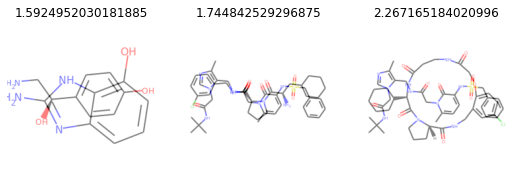

In [27]:
dls.show_batch(max_n=3)

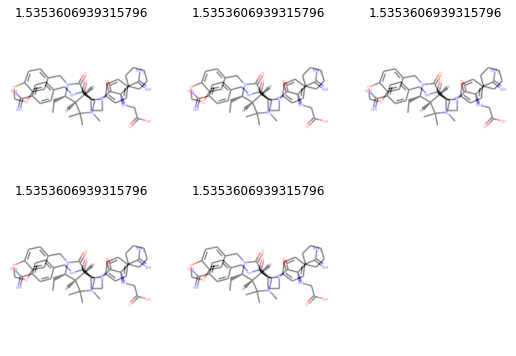

In [28]:
dls.show_batch(max_n=5, unique=True)

# Train CNN regression model

In [46]:
from sklearn.metrics import explained_variance_score

In [29]:
learn = cnn_learner(dls, arch=resnet18, pretrained=True, 
                            loss_func=None,
                            wd=None, metrics = rmse)

In [ ]:
learn.fine_tune(16, 3e-3)

In [51]:
def train_model(dls, arch=resnet18, loss_func=None, epochs=16, wd=None, lr=None):
    
    
    print(f'Architechture: {arch}')
    #print(f'Untrained epochs: freeze_epochs={freeze_epochs}')
    print(f'Trained epochs: epochs={epochs}')
    print(f'Weight decay: wd={wd}')
    learn = cnn_learner(dls, arch=arch, pretrained=True, 
                            wd=wd,
                            metrics=[rmse, exp_rmspe, ExplainedVariance(), R2Score(), PearsonCorrCoef()])
    
    if lr == None: 
        print(f'Finding learning rate...')
        lr_min, lr_steep = learn.lr_find(suggestions=True, show_plot=False)
        print(f'Training model with learning rate: {lr_min}')
        lr = lr_min
    else: 
        print(f'Training model with learning rate: {lr}')
    learn.fine_tune(epochs, lr)
    
    return learn

In [50]:
learn = train_model(dls, epochs=16, wd=0.001)

Architechture: <function resnet18 at 0x7f891ccf6e18>
Trained epochs: epochs=16
Weight decay: wd=0.001
Finding learning rate...


Training model with learning rate: 0.010000000149011612


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,time
0,0.896522,0.691466,0.831544,2.081831,0.087311,00:49


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,time


KeyboardInterrupt: 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(k=10)

# Test different regularizations

## Results:
### wd = ? 
### lr = ? 
### dropout = 0.5 is a usually sustainable

In [38]:
from sklearn.model_selection import ParameterGrid

In [52]:
# batch_size = 64
param_grid={
    'wd' : [0.002, 0.001],
    'lr' : [2e-2, 1e-2, 3e-3, 1e-3],
}
param_grid = ParameterGrid(param_grid)

for p in param_grid:
    learn = train_model(dls, epochs=16, wd=p['wd'], lr=p['lr'])

Architechture: <function resnet18 at 0x7f891ccf6e18>
Trained epochs: epochs=16
Weight decay: wd=0.01
Training model with learning rate: 0.02


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.891606,0.686654,0.828646,3.292810,0.090101,0.089451,0.324310,00:49


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.480815,0.459081,0.677555,1.306427,0.401745,0.391227,0.637697,01:04
1,0.470140,0.433306,0.658260,1.509909,0.434077,0.425407,0.663375,01:05
2,0.449188,0.434928,0.659491,1.574438,0.426044,0.423255,0.652762,01:04
3,0.412024,0.553988,0.744304,0.917238,0.453551,0.265374,0.673464,01:04
4,0.363097,0.461732,0.679509,1.851446,0.477773,0.387712,0.694535,01:04
5,0.353328,0.682432,0.826095,0.951959,0.387288,0.095049,0.639312,01:04
6,0.313601,0.425552,0.652343,0.945342,0.492967,0.435689,0.715372,01:05
7,0.291962,0.387621,0.622592,1.021782,0.505920,0.485988,0.713120,01:05
8,0.272376,0.374312,0.611811,1.139449,0.508759,0.503637,0.715240,01:04
9,0.240099,0.403382,0.635124,1.375810,0.484367,0.465088,0.718533,01:04


Architechture: <function resnet18 at 0x7f891ccf6e18>
Trained epochs: epochs=16
Weight decay: wd=0.005
Training model with learning rate: 0.02


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.876609,0.683300,0.826619,1.508940,0.135966,0.093899,0.461862,00:51


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.484762,0.577676,0.760050,1.042406,0.375409,0.233962,0.612928,01:05
1,0.448758,0.431451,0.656850,1.609374,0.434242,0.427866,0.661046,01:05
2,0.422380,0.465943,0.682600,1.339067,0.383187,0.382129,0.630663,01:05
3,0.395672,0.508467,0.713069,0.970214,0.435200,0.325739,0.666985,01:05
4,0.371038,0.478608,0.691815,1.327079,0.375769,0.365333,0.671357,01:05
5,0.334076,0.452603,0.672757,1.736192,0.463782,0.399818,0.695830,01:05
6,0.309263,0.375019,0.612388,1.092902,0.517369,0.502699,0.720792,01:05
7,0.289951,0.364784,0.603973,1.326433,0.516880,0.516272,0.720351,01:05
8,0.260989,0.427013,0.653462,0.980499,0.491909,0.433752,0.701684,01:04
9,0.252674,0.373433,0.611092,1.265379,0.510498,0.504802,0.722719,01:05


Architechture: <function resnet18 at 0x7f891ccf6e18>
Trained epochs: epochs=16
Weight decay: wd=0.002
Training model with learning rate: 0.02


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.889835,0.602468,0.776188,2.120090,0.204209,0.201087,0.484807,00:51


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.485996,0.493019,0.702153,1.456181,0.361670,0.346223,0.606433,01:05
1,0.456841,0.461000,0.678970,1.314800,0.412163,0.388682,0.649292,01:05
2,0.411577,0.559155,0.747767,1.322122,0.294310,0.258522,0.647130,01:05
3,0.386292,0.465353,0.682168,1.503728,0.385000,0.382910,0.679990,01:05
4,0.363168,0.550202,0.741756,1.064806,0.400658,0.270395,0.633207,01:06
5,0.347047,0.383185,0.619020,1.176937,0.494392,0.491870,0.703243,01:05
6,0.302566,0.379814,0.616291,1.179085,0.498025,0.496340,0.706304,01:05
7,0.289148,0.379963,0.616412,1.297030,0.498196,0.496143,0.710921,01:05
8,0.264653,0.385746,0.621084,1.220386,0.489556,0.488475,0.709918,01:05
9,0.239084,0.384472,0.620058,1.204951,0.490174,0.490165,0.716788,01:05


Architechture: <function resnet18 at 0x7f891ccf6e18>
Trained epochs: epochs=16
Weight decay: wd=0.001
Training model with learning rate: 0.02


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.873850,0.731529,0.855295,2.796213,0.156892,0.029943,0.439747,00:50


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.476675,0.463302,0.680663,1.494722,0.386313,0.385631,0.621566,01:05
1,0.443040,0.448871,0.669978,1.138368,0.427652,0.404767,0.655319,01:05
2,0.435280,0.637156,0.798221,1.004727,0.422907,0.155088,0.654043,01:05
3,0.397803,0.425881,0.652596,1.384979,0.438894,0.435253,0.663293,01:05
4,0.361630,0.383921,0.619614,1.288335,0.491058,0.490894,0.700795,01:05
5,0.332308,0.467173,0.683501,0.944436,0.474838,0.380497,0.690527,01:05
6,0.323166,0.406514,0.637585,1.037479,0.504434,0.460935,0.710238,01:06
7,0.288452,0.405995,0.637177,1.466720,0.470102,0.461624,0.716851,01:06
8,0.261107,0.380461,0.616815,1.348976,0.500648,0.495483,0.709010,01:06
9,0.248720,0.371574,0.609569,1.172684,0.507749,0.507267,0.725387,01:05


Architechture: <function resnet18 at 0x7f891ccf6e18>
Trained epochs: epochs=16
Weight decay: wd=0.01
Training model with learning rate: 0.01


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.857745,0.703703,0.838870,2.158702,0.100838,0.066842,0.367756,00:52


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.483899,0.431755,0.657081,1.357234,0.427525,0.427463,0.661080,01:05
1,0.472225,0.476980,0.690638,1.304558,0.377202,0.367492,0.616972,01:05
2,0.440386,0.508728,0.713252,0.912960,0.478533,0.325392,0.698030,01:06
3,0.429400,0.405402,0.636712,1.381297,0.466964,0.462409,0.688159,01:06
4,0.374230,0.428133,0.654319,1.465407,0.432652,0.432267,0.677371,01:06
5,0.337715,0.366311,0.605237,1.126177,0.519230,0.514246,0.725971,01:06
6,0.291765,0.388551,0.623339,1.325462,0.489353,0.484755,0.725636,01:05
7,0.265640,0.389061,0.623747,1.188219,0.486704,0.484079,0.734136,01:05
8,0.243457,0.361141,0.600950,1.274805,0.530611,0.521102,0.728694,01:05
9,0.224441,0.368173,0.606773,1.088726,0.515706,0.511777,0.724754,01:06


Architechture: <function resnet18 at 0x7f891ccf6e18>
Trained epochs: epochs=16
Weight decay: wd=0.005
Training model with learning rate: 0.01


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.889932,0.675475,0.821873,2.015003,0.105446,0.104274,0.417404,00:52


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.477594,0.447696,0.669101,1.415604,0.409716,0.406325,0.644182,01:06
1,0.440442,0.498255,0.705872,1.066654,0.419683,0.339280,0.650509,01:06
2,0.458861,0.654875,0.809244,1.177181,0.327188,0.131591,0.578656,01:05
3,0.417830,0.423627,0.650866,1.347395,0.438788,0.438242,0.675113,01:06
4,0.379855,0.410595,0.640777,1.106005,0.478900,0.455523,0.692086,01:06
5,0.332230,0.391394,0.625615,1.378277,0.492882,0.480986,0.708943,01:06
6,0.293012,0.407754,0.638556,1.384064,0.489811,0.459290,0.712009,01:06
7,0.261106,0.439414,0.662883,0.965119,0.473072,0.417307,0.705796,01:05
8,0.247175,0.359677,0.599731,1.168215,0.524021,0.523044,0.723930,01:07
9,0.228620,0.384456,0.620045,1.197915,0.491462,0.490186,0.719444,01:07


Architechture: <function resnet18 at 0x7f891ccf6e18>
Trained epochs: epochs=16
Weight decay: wd=0.002
Training model with learning rate: 0.01


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.892886,0.673632,0.820751,1.931525,0.109814,0.106719,0.416317,00:52


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.491218,0.442029,0.664853,1.240948,0.417422,0.413839,0.647590,01:06
1,0.468855,0.450118,0.670909,1.344616,0.403130,0.403112,0.647092,01:06
2,0.448712,0.465423,0.682219,1.074837,0.433885,0.382818,0.660690,01:07
3,0.445406,0.456088,0.675343,1.289526,0.395365,0.395197,0.665201,01:06
4,0.397401,0.503578,0.709632,1.326740,0.386497,0.332222,0.624793,01:06
5,0.320392,0.377767,0.614628,1.271921,0.499292,0.499055,0.707320,01:06
6,0.313403,0.421759,0.649430,1.048970,0.480803,0.440719,0.694345,01:06
7,0.274678,0.406121,0.637276,0.953147,0.492263,0.461457,0.715785,01:06
8,0.253483,0.378333,0.615088,0.971732,0.533005,0.498305,0.730194,01:06
9,0.245531,0.404216,0.635780,1.448297,0.495039,0.463982,0.718170,01:06


Architechture: <function resnet18 at 0x7f891ccf6e18>
Trained epochs: epochs=16
Weight decay: wd=0.001
Training model with learning rate: 0.01


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.867763,0.724712,0.851300,1.630520,0.065167,0.038982,0.418958,00:52


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.494132,0.437923,0.661758,1.273485,0.433504,0.419284,0.658598,01:06
1,0.455404,0.481140,0.693643,1.261272,0.381670,0.361975,0.619208,01:06
2,0.451899,0.424657,0.651657,1.198042,0.453156,0.436876,0.673388,01:08
3,0.421999,0.428244,0.654403,1.244361,0.439723,0.432120,0.664159,01:07
4,0.386754,0.516668,0.718796,1.037887,0.426270,0.314863,0.678918,01:07
5,0.333048,0.377129,0.614108,1.091066,0.506236,0.499901,0.720684,01:07
6,0.292315,0.387924,0.622835,1.123534,0.490653,0.485587,0.701816,01:07
7,0.275441,0.364442,0.603690,1.057984,0.518096,0.516725,0.720842,01:07
8,0.244280,0.381041,0.617285,1.212082,0.494827,0.494714,0.706068,01:07
9,0.228392,0.388766,0.623511,1.198797,0.484911,0.484470,0.723167,01:07


Architechture: <function resnet18 at 0x7f891ccf6e18>
Trained epochs: epochs=16
Weight decay: wd=0.01
Training model with learning rate: 0.003


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time
0,0.955599,0.626024,0.791217,1.594688,0.185976,0.169850,0.463936,00:52


epoch,train_loss,valid_loss,_rmse,_exp_rmspe,explained_variance_score,r2_score,pearsonr,time


Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/kjetil/anaconda3/envs/dat255-drug/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/kjetil/anaconda3/envs/dat255-drug/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/kjetil/anaconda3/envs/dat255-drug/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/home/kjetil/anaconda3/envs/dat255-drug/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/kjetil/anaconda3/envs/dat255-drug/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/home/kjetil/anaconda3/envs/dat255-drug/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/home/kjetil/anaconda3/e

KeyboardInterrupt: 

# Compare architechtures

**Results:** Not much difference between **Resnet18, Resnet34 and Resnet50** on (224, 224) size images. \
**Alexnet** got worse results then **resnet**. \
Reason could be that the extra layers is not much of a use in this case (i.e. The images does not contain a lot of details) \
**Resnet18** takes less time to train due to less layers and therefore should be used in this case. 

In [ ]:
archs =  [resnet18, resnet50, alexnet]

In [ ]:
for arch in archs:
    train_model(dls, arch=arch, epochs=15, lr=3e-3)